## Install libraries first

Be sure  keras with tensorflow installed
`!conda install -c conda-forge keras`


In [ ]:
!pip install git+https://github.com/qubvel/efficientnet
!pip install git+https://github.com/qubvel/classification_models.git
!pip install git+https://github.com/qubvel/segmentation_models
!pip install -U git+https://github.com/albu/albumentations
!pip install tta-wrapper

## Defining data generator

In [1]:
from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
import albumentations as albu
from albumentations import Resize

class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'../data/val_test', image_folder='images/', mask_folder='groundtruth/', 
                 batch_size=1, image_size=384, nb_y_features=1, 
                 augmentation=None,
                 suffle=True):
        self.root_dir = root_dir
        self.image_filenames = os.listdir(os.path.join(root_dir, image_folder))
        for i in range(len(self.image_filenames)):
            self.image_filenames[i] = os.path.join(os.path.join(root_dir, image_folder), self.image_filenames[i])

        self.mask_names = os.listdir(os.path.join(root_dir, mask_folder))
        
        for i in range(len(self.image_filenames)):
            self.mask_names[i] = os.path.join(os.path.join(root_dir, mask_folder), self.mask_names[i])
            
            
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name):
        return (imread(image_name)/255).astype(np.float32), (imread(mask_name, as_gray=True) > 0).astype(np.int8)

    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)

        for i, sample_index in enumerate(indexes):

            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i])
                 
            # if augmentation is defined, we assume its a train set
            if self.augmentation is not None:
                  
                # Augmentation code
                augmented = self.augmentation(self.image_size)(image=X_sample, mask=y_sample)
                image_augm = augmented['image']
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                y[i, ...] = mask_augm
            
            # if augmentation isnt defined, we assume its a test set. 
            # Because test images can have different sizes we resize it to be divisable by 32
            elif self.augmentation is None and self.batch_size ==1:
                X_sample, y_sample = self.read_image_mask(self.image_filenames[index * 1 + i], 
                                                      self.mask_names[index * 1 + i])
                augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                X_sample, y_sample = augmented['image'], augmented['mask']

                return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)

        return X, y

Using TensorFlow backend.


## Data augmentation - albumentations

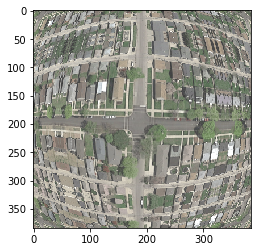

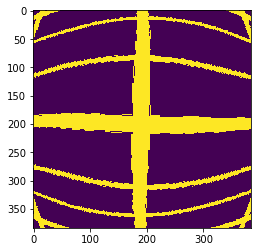

In [2]:
def aug_with_crop(image_size = 256, crop_prob = 1):
    return Compose([
        RandomCrop(width = image_size, height = image_size, p=crop_prob),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.25),
        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

test_generator = DataGeneratorFolder(root_dir = '../../data/training',
                                     image_folder = 'images/', 
                                     mask_folder = 'groundtruth/',
                                     batch_size = 1,
                                     nb_y_features = 1, augmentation = aug_with_crop)
print(test_generator)
Xtest, ytest = test_generator.__getitem__(0)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show() 

In [3]:
# setting generators
test_generator = DataGeneratorFolder(root_dir = '../../data/training', 
                           image_folder = 'images/', 
                           mask_folder = 'groundtruth/', 
                                   batch_size=1,augmentation = aug_with_crop,
                                   nb_y_features = 1)

train_generator = DataGeneratorFolder(root_dir = '../../data/training', 
                                      image_folder = 'test_images/', 
                                      mask_folder = 'test_groundtruth/', 
                                      augmentation = aug_with_crop,
                                      batch_size=1,
                                      image_size=384,
                                      nb_y_features = 1)
print(len(test_generator))
print(len(train_generator))

50
50


## Callbacks

In [4]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("./weights/road_crop.efficientnetb0imgsize.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =1)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=100, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tensorboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

Segmentation Models: using `keras` framework.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
50/50 [==============================] - 269s 5s/step - loss: 1.4083 - iou_score: 0.1811 - val_loss: 4.2348 - val_iou_score: 0.0085

Epoch 00001: val_iou_score improved from -inf to 0.00846, saving model to ./weights/road_crop.efficientnetb0imgsize.h5
Epoch 2/50
50/50 [==============================] - 252s 5s/step - loss: 1.3054 - iou_score: 0.2173 - val_loss: 1.6495 - val_iou_score: 0.1911

Epoch 00002: val_iou_score improved from 0.00846 to 0.19114, saving model to ./weights/road_crop.efficientnetb0imgsize.h5
Epoch 3/50
50/50 [==============================] - 252s 5s/step - loss: 1.2204 - iou_score: 0.2573 - val_loss: 2.7555 - val_iou_score: 0.2095

Epoch 00003: val_iou_score improved from 0.19114 to 0.20948, saving model to ./weights/road_crop.efficientnetb0imgsize.h5
Epoch 4/50
50/50 [=====================

50/50 [==============================] - 268s 5s/step - loss: 0.7987 - iou_score: 0.5234 - val_loss: 0.6254 - val_iou_score: 0.3817

Epoch 00035: val_iou_score did not improve from 0.40618
Epoch 36/50
50/50 [==============================] - 276s 6s/step - loss: 0.7285 - iou_score: 0.5563 - val_loss: 1.0197 - val_iou_score: 0.3123

Epoch 00036: val_iou_score did not improve from 0.40618
Epoch 37/50
50/50 [==============================] - 281s 6s/step - loss: 0.7487 - iou_score: 0.5461 - val_loss: 0.7092 - val_iou_score: 0.3477

Epoch 00037: val_iou_score did not improve from 0.40618
Epoch 38/50
50/50 [==============================] - 265s 5s/step - loss: 0.7243 - iou_score: 0.5564 - val_loss: 1.2452 - val_iou_score: 0.3242

Epoch 00038: val_iou_score did not improve from 0.40618
Epoch 39/50
50/50 [==============================] - 258s 5s/step - loss: 0.7881 - iou_score: 0.5142 - val_loss: 0.7451 - val_iou_score: 0.4411

Epoch 00039: val_iou_score improved from 0.40618 to 0.44113, sa

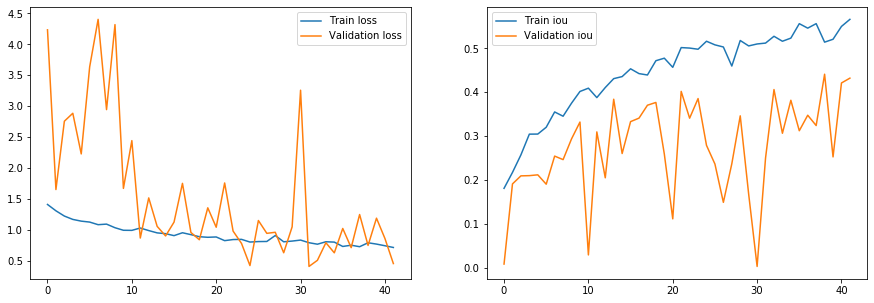

In [5]:
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score

def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
    
model = Unet(backbone_name = 'efficientnetb0', encoder_weights=None, encoder_freeze = False)
model.compile(optimizer = Adam(),
                    loss=bce_jaccard_loss, metrics=[iou_score])

history = model.fit_generator(train_generator, shuffle =True,
                  epochs=50, workers=1, use_multiprocessing=False,
                  validation_data = test_generator, 
                  verbose = 1, callbacks=callbacks)
#plotting history
plot_training_history(history)

## Inference and model quality  check

#### Single image

In [22]:
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def plot_mask_gt_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Blues")
    axs[0].set_title('mask')
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[1].set_title('groundtruth')
    axs[2].imshow(img)
    axs[2].set_title('img')
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

# to get single image and prediction quality
Xtest, y_test  = test_generator.__getitem__(1)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(384, 384)
print('IOU', iou_metric(y_test[0].reshape(384, 384), predicted)) 

IOU [[0.64518227]]


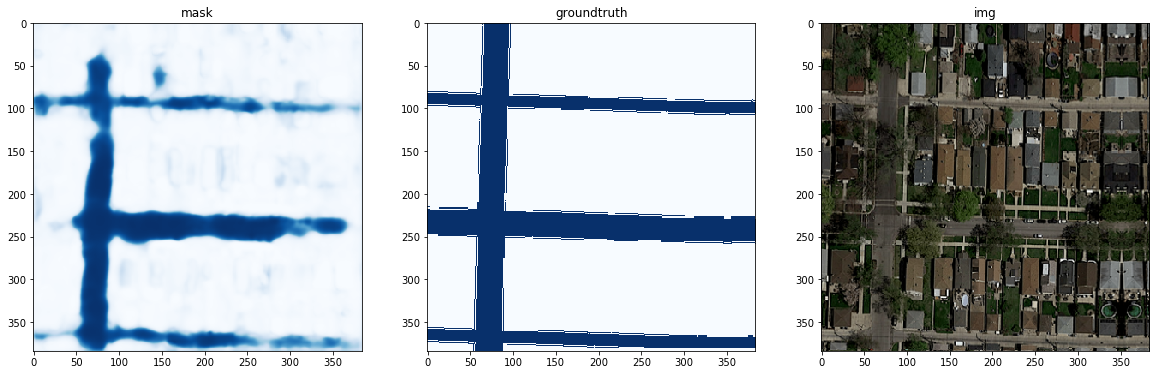

In [23]:
plot_mask_gt_image(predicted, y_test.squeeze(0).squeeze(-1),\
           Xtest.squeeze(0))

## Overall quality

In [14]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))  

Loss: 1.7947
mean iou_score: 0.4046


## Adding TTA (test time augmentation)

In [16]:
from tta_wrapper import tta_segmentation
from keras.models import load_model
model = load_model('./weights/road_crop.efficientnetb0imgsize.h5', 
                   custom_objects={'binary_crossentropy + jaccard_loss': bce_jaccard_loss,
                                   'iou_score': iou_score})
tta_model = tta_segmentation(model, h_flip=True, merge='mean').compile(optimizer = Adam(), loss=bce_jaccard_loss, metrics=[iou_score])
scores = tta_model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value)) 

ValueError: Unknown loss function:binary_crossentropy_plus_jaccard_loss

### By adjusting threshold you can further improve your score

In [17]:
def draw_get_best_threshold(ious, thresholds):
    """
    Returns threshold_best, iou_best
    """
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    return threshold_best, iou_best

preds = []
y_val = []
for i in (range(0,test_generator.__len__())):
    Xtest, y_test  = test_generator.__getitem__(i)
    preds.append(tta_model.predict(Xtest).reshape(1472, 1472))
    y_val.append(y_test)
preds = np.stack(preds, axis=0)
y_val = np.stack(y_val, axis=0)

thresholds = list(np.linspace(0.1, 0.9, 10))
ious = np.array([iou_metric_batch(y_val, np.int32(preds > threshold)) for threshold in (thresholds)])

best_threshold, best_iou = draw_get_best_threshold(ious, thresholds)

NameError: name 'tta_model' is not defined